# Traffic Density VS Tourist & Citizen Travel
    Joseph Antony
    17th June 2023

In [1]:
import warnings
import numpy as np

import polars as pl
pl.enable_string_cache(True)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

from sklearn.preprocessing import MinMaxScaler

In [2]:
%%time

select_Cols = [
    'DATE_TIME', 'GEOHASH', 'NUMBER_OF_VEHICLES', 'CITIZEN_RETURN', 
    'CITIZEN_ARRIVAL', 'TOURIST_ARRIVAL', 'IS_COVID_RESTRICTION'
]

pl_df = (
    pl.scan_parquet("datasets/00_tr_df_merged/tr_ist_td_merged_full.zstd")
    .select(select_Cols)
    .with_columns(pl.col('DATE_TIME').dt.month().alias('MONTH').cast(pl.UInt8),
                  pl.col('DATE_TIME').dt.year().alias('YEAR').cast(pl.UInt16))
).collect(streaming=True)

pl_df.head()

Wall time: 20.6 s


DATE_TIME,GEOHASH,NUMBER_OF_VEHICLES,CITIZEN_RETURN,CITIZEN_ARRIVAL,TOURIST_ARRIVAL,IS_COVID_RESTRICTION,MONTH,YEAR
datetime[ns],cat,u16,u32,u32,u32,bool,u8,u16
2020-01-01 00:00:00,"""sxkbj3""",97,627933,692729,1017034,false,1,2020
2020-01-01 01:00:00,"""sxkbj3""",58,627933,692729,1017034,false,1,2020
2020-01-01 02:00:00,"""sxkbj3""",40,627933,692729,1017034,false,1,2020
2020-01-01 03:00:00,"""sxkbj3""",33,627933,692729,1017034,false,1,2020
2020-01-01 04:00:00,"""sxkbj3""",25,627933,692729,1017034,false,1,2020


In [3]:
def plot_travel(col):
    color=['blue', 'red']

    ax = (
        pl_df.lazy()
        .groupby(['YEAR', 'MONTH', 'IS_COVID_RESTRICTION'])
        .agg(pl.col(col).mean())
        .collect(streaming=True)
        .pivot(index=['YEAR', 'MONTH'], columns='IS_COVID_RESTRICTION', values=col, 
            aggregate_function='sum')
        .lazy()
        .sort(['YEAR', 'MONTH'])
        .with_columns(pl.concat_str(pl.col('YEAR').cast(pl.Utf8),
                                pl.col('MONTH').cast(pl.Utf8),
                                separator="_"))
        .drop('MONTH')
        .select(['YEAR', 'false', 'true'])
        .collect(streaming=True)
        .to_pandas()
        .assign(true=lambda x: np.where(x['true'].isnull() & x['true'].shift().notnull(), x['false'], x['true']))
        .set_index('YEAR')
        .plot(figsize=(10, 3), title=f'{col.replace("_", " ").title()} Time Series', 
              color=color, marker="*", mfc="k", mec="k", rot=45)
    )

    ax.set_ylabel("Total Travelers")
    ax.legend(title="IS_COVID_RESTRICTION")
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))

    plt.show();

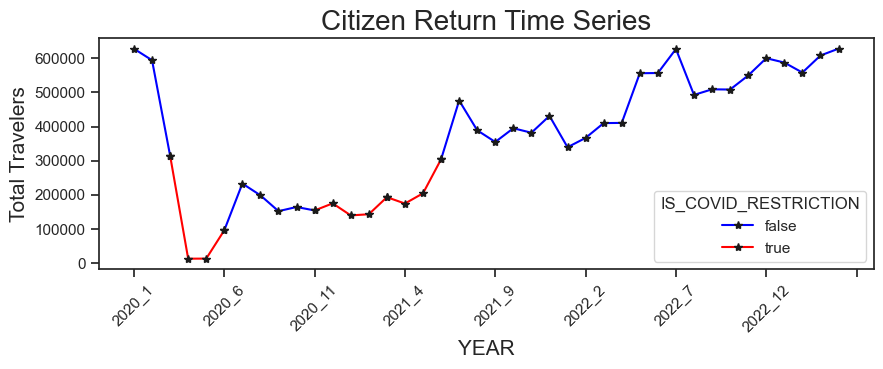

In [4]:
plot_travel('CITIZEN_RETURN')

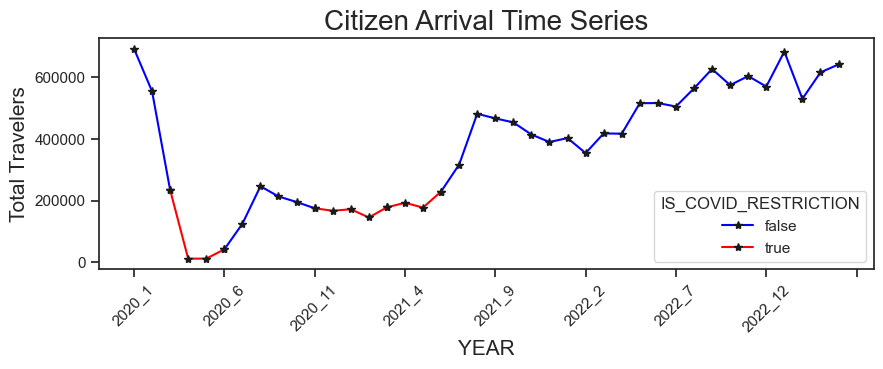

In [5]:
plot_travel('CITIZEN_ARRIVAL')

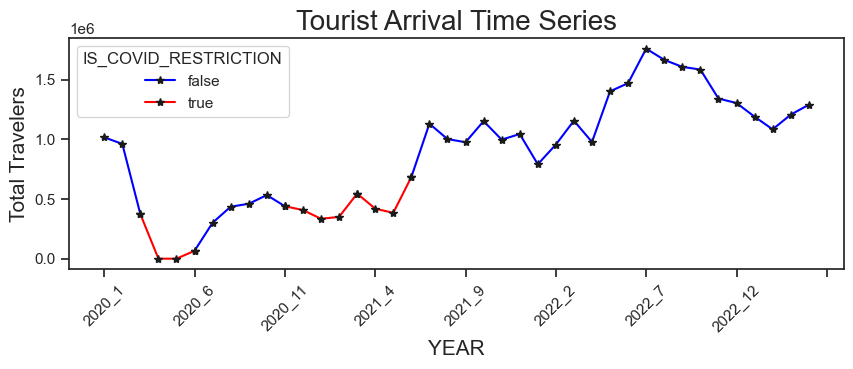

In [6]:
plot_travel('TOURIST_ARRIVAL')

    For all the above plots, during COVID restrictions, the number of travelers (tourist arrivals, citizen traveling from and to Istanbul) declines. During no COVID restrictions, the number of travelers increases significantly. 

    The first COVID restrictions during March 2020 saw the lowest drop in travelers compared to other COVID restrictions during 2021.

In [7]:
def yr_mnth_trvl_plot(col):

    month_labels=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    ax = (
        pl_df.groupby(['YEAR', 'MONTH'], maintain_order=True)
        .agg(pl.col(col).mean())
        .pivot(index='MONTH', columns='YEAR', values=col)
        .to_pandas()
        .set_index('MONTH')
        .plot(figsize=(10, 3), marker="o", mec="k", lw=3, title=f'Monthly {col.replace("_", " ").title()} by Year')
    )

    ax.set_ylabel("Total Travelers")
    ax.set_xlabel("")
    ax.set_xticks(ticks=np.arange(1, 13, 1), labels=month_labels)
    ax.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.3))
    
    plt.show();

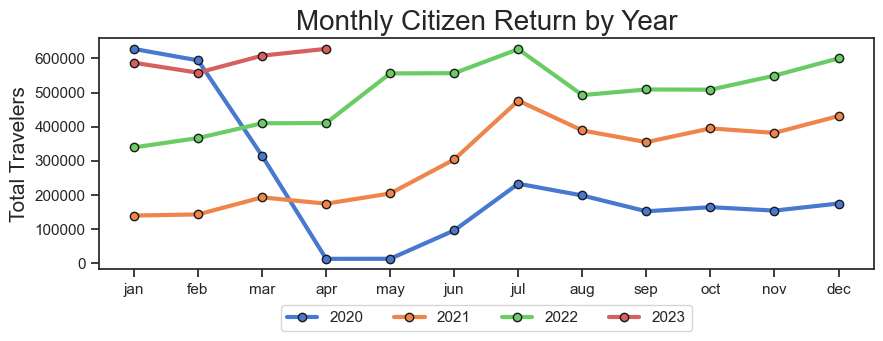

In [8]:
yr_mnth_trvl_plot('CITIZEN_RETURN')

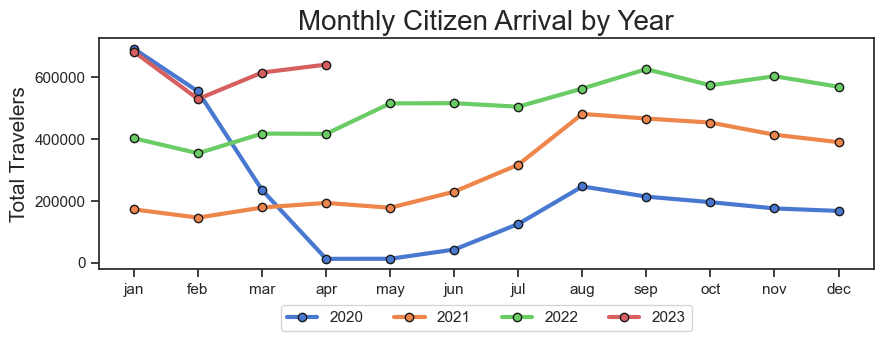

In [9]:
yr_mnth_trvl_plot('CITIZEN_ARRIVAL')

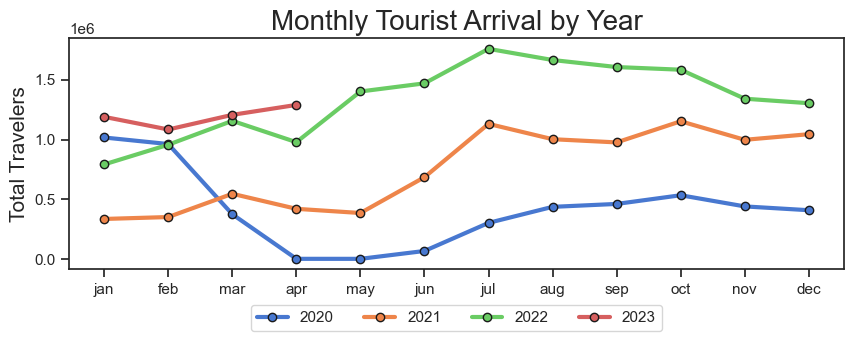

In [10]:
yr_mnth_trvl_plot('TOURIST_ARRIVAL')

    In all the above three plots, there is a sharp decline in travelers since March 2020. But, since 2021, the number of travelers to and from Istanbul increases. 2022 saw the highest number of travelers. 

    For 2023, although data is only available till April, the mean number of travelers from Jan ro April was the highest compared to the same months from previous years. 

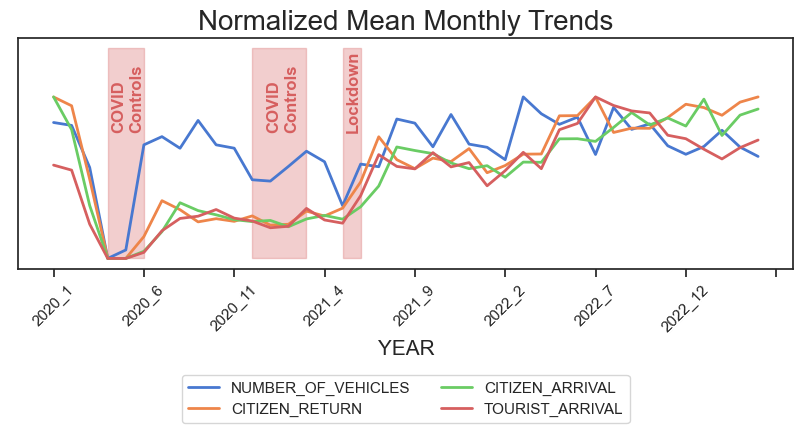

In [11]:
# To scale values to ensure range between 0 and 1
scaler = MinMaxScaler()

# Group by year and month and select columns. Combine year and month into strings.
temp_df = (
    pl_df.groupby(['YEAR', 'MONTH'], maintain_order=True)
    .agg(pl.col(['NUMBER_OF_VEHICLES', 'CITIZEN_RETURN', 'CITIZEN_ARRIVAL', 
                    'TOURIST_ARRIVAL']).mean())
    .with_columns(pl.concat_str(pl.col('YEAR').cast(pl.Utf8),
                                pl.col('MONTH').cast(pl.Utf8),
                                separator="_"))
    .drop('MONTH')
)

# Scale the values and then plot time series
ax = (
    pl.DataFrame(scaler.fit_transform(temp_df[['NUMBER_OF_VEHICLES', 'CITIZEN_RETURN', 
                                                'CITIZEN_ARRIVAL', 'TOURIST_ARRIVAL']]))
    .rename({'column_0' : 'NUMBER_OF_VEHICLES', 'column_1' : 'CITIZEN_RETURN', 
                'column_2' : 'CITIZEN_ARRIVAL', 'column_3' : 'TOURIST_ARRIVAL'})
    .with_columns(pl.Series('YEAR', temp_df['YEAR']))
    .to_pandas()
    .set_index('YEAR')
    .plot(figsize=(10, 3), rot=45, lw=2, title='Normalized Mean Monthly Trends')
)

plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))

# Covid 1st Restriction Months in 2020
ax.fill_between(x=(3, 5), y1=0, y2=1.3, color='r', alpha = 0.3)
ax.text(3.2, 0.8, "COVID\nControls", fontsize=12, fontweight='bold', rotation=90, c='r')

# Covid 2nd Restriction months in 2021
ax.fill_between(x=(11, 14), y1=0, y2=1.3, color='r', alpha = 0.3)
ax.text(11.8, 0.8, "COVID\nControls", fontsize=12, fontweight='bold', rotation=90, c='r')

# Covid Lockdown months in 2021
ax.fill_between(x=(16, 17), y1=0, y2=1.3, color='r', alpha = 0.3)
ax.text(16.2, 0.8, "Lockdown", fontsize=12, fontweight='bold', rotation=90, c='r')

ax.set_yticks([])
ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.7));

    The above plotshows the mean monthly time series for number of vehicles, citizens travel to and from Istanbul and Tourists arriving to Istanbul. All four variables were scaled to values between 0 and 1. Its clear that all 4 variables move in similar patterns. 

    As seen from previous plots, March 2020 saw the highest drop in trend for all four variables, before picking up again gradually during June 2020. There is a slight downard trend again during the start of November 2020, followed by an even lower decline on April 2021, which was a nation wide lockdown.

    By the end of the lockdown in June 2021, all four variables has been on an upward trend ever since.

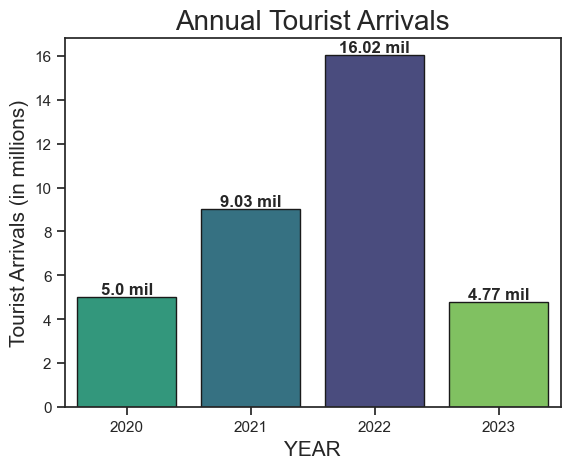

In [35]:
temp_df = (
    pl_df.lazy()
    .groupby(['MONTH', 'YEAR'])
    .agg(pl.col('TOURIST_ARRIVAL').mean())
    .groupby('YEAR')
    .agg(pl.col('TOURIST_ARRIVAL').sum())
    .sort('YEAR')
    .with_columns(pl.col('TOURIST_ARRIVAL')/1e6)
    .collect(streaming=True)
    .to_pandas()
)


ax = sns.barplot(
    x='YEAR',
    y='TOURIST_ARRIVAL',
    hue='TOURIST_ARRIVAL',
    data=temp_df,
    dodge=False,
    edgecolor='k',
    palette="viridis_r"

)

for c in ax.containers:
    labels = [f'{np.round(v, 2)} mil' for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="edge", fontweight = "bold")

ax.legend().remove()
ax.set_title("Annual Tourist Arrivals")
ax.set_ylabel("Tourist Arrivals (in millions)");